# Bayesian Inference II: Bayesian Linear Regression
### Implemented in R and RStan

<img src="img/bi2.png" style="height: 350px; width:auto;">

# Outline

- Recap
- Solving the Posterior
- Normal Linear Regression
- Penalized Regression
- The Urinalysis Dataset
- Software
- Implementation
- Robust Linear Regression
- What's Next?

# Recap

The previous article introduced Bayesian data analysis as a paradigm of statistics in which prior distributions of parameters are considered, and naturally probabilistic interpretations are obtained. Whereas the frequentist view treats data as random, and parameters as fixed, Bayesian models treat data as fixed, and parameters as random.

We apply Bayes' theorem to estimate the parameters $\theta$ given the data $y$, explaining our belief about how the value of $\theta$ evolves following observation of data.

$f(\theta|y) = \frac{ f(y|\theta) ~f(\theta) }{ \int f(y|\theta) ~f(\theta) ~d \theta }$

$f(\theta|y)$ is our posterior distribution, which takes into account both the data and the prior distribution, reflecting our expectations external to the data. $f(\theta)$ is the prior, and $f(y|\theta)$ is the likelihood of the data given the parameters.

# Solving the Posterior

To solve for the posterior, we will utilize approximation sampling, which allows us to specify any pair of distributions for the prior and the likelihood. It is a powerful tool that has grown in capability over the years, but is still significantly slower than closed-form solution using conjugate priors.

Markov Chain Monte Carlo (MCMC) sampling is our alternative to closed-form computation, which leverages the central limit theorem to derive statistical estimates through samples that approximate the true value of the target distribution. Many algorithms, such as the Metropolis-Hastings algorithm, use an acceptance-rejection mechanism that is essential to ensuring the success of sampling.

The approximation sampling is largely treated as a black-box inference button, but it is important to examine the performance of sampling. Popular software like PyMC and Stan will provide warnings, such as when sampling chains do not converge. 

# Normal Linear Regression

Linear regression can be thought of as an extension of the Normal model where the mean is a linear function of a predictor variable. It’s no coincidence; assuming normally distributed errors makes least squares equivalent to maximum likelihood estimation. In the next article, we will discuss generalized linear models (in a Bayesian context), which use alternative distributions to the Normal, such as those which produce only positive or positive-integer results.

We simply treat the mean $\mu$ of the Normally distributed data as a linear regression function.

$y \sim \mathcal{N}(\alpha + \beta X, \sigma)$

$\alpha$ is our intercept, $\beta$ our vector of coefficients, and $\mathbf{X}$ our design matrix. $\sigma$ is strictly positive, so it is common to use a distribution like the Exponential or Half-Normal as a prior.

# Penalized Regression

There is an interesting relationship between penalized least-squares regression and Bayesian priors. The last chapter of <a href="https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC3.ipynb">Bayesian Methods for Hackers</a> shows that Ridge regression corresponds to the MAP of a linear model with Normal errors and a Normal prior on $\beta$.

- $\hat{\beta} = \displaystyle \arg \min_{\substack{\beta}} (Y - X \beta)^T (Y - X \beta) + \alpha ||\beta||_2^2$

And Lasso regression corresponds to a Normal regression with a Laplace prior on 𝛽.

- $\hat{\beta} = \displaystyle \arg \min_{\substack{\beta}} (Y - X \beta)^T (Y - X \beta) + \alpha ||\beta||_1$

# The Urinalysis Dataset

In this and coming articles, we will work with the urinalysis dataset found in the boot package of R. The data include 79 samples, with the following features:

- <code>r</code>: indicator of the presence of calcium oxalate crystals.
- <code>gravity</code>: density dependent on dissolved particulates.
- <code>ph</code>: level of acidity or alkalinity
- <code>osmo</code>: osmolarity; proportional to the concentration of molecules in solution.
- <code>cond</code>: conductivity; proportional to the concentration of charged ions in solution.
- <code>urea</code>: urea concentration in millimoles per litre.
- <code>calc</code>: calcium concentration in millimoles per litre.

We’ll focus on the relationship between gravity and osmo, which I’ll plot below.

In [ ]:
# install.packages('boot')
# install.packages('rstan')

library(boot)
library(rstan)
library(ggplot2)
library(gridExtra)

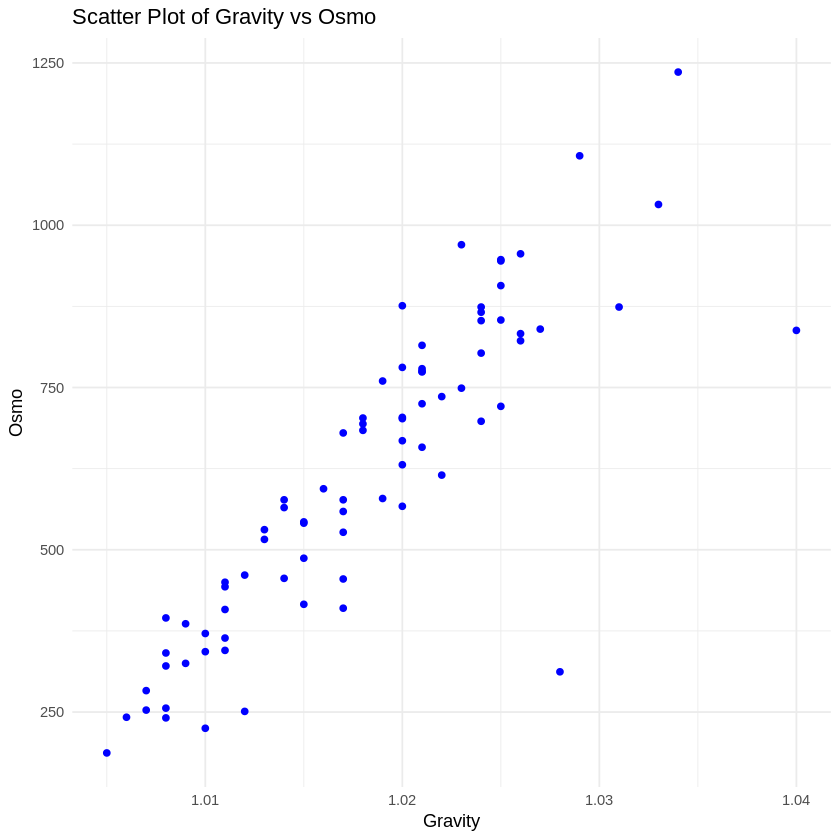

In [2]:
data <- urine
data$osmo[is.na(data$osmo)] <- mean(data$osmo, na.rm = TRUE)

ggplot(data, aes(x = gravity, y = osmo)) +
  geom_point(color = "blue") +
  labs(x = "Gravity", y = "Osmo", title = "Scatter Plot of Gravity vs Osmo") +
  theme_minimal()

We'll standardize the data, to make the interpretation of intercept and slope units more natural.

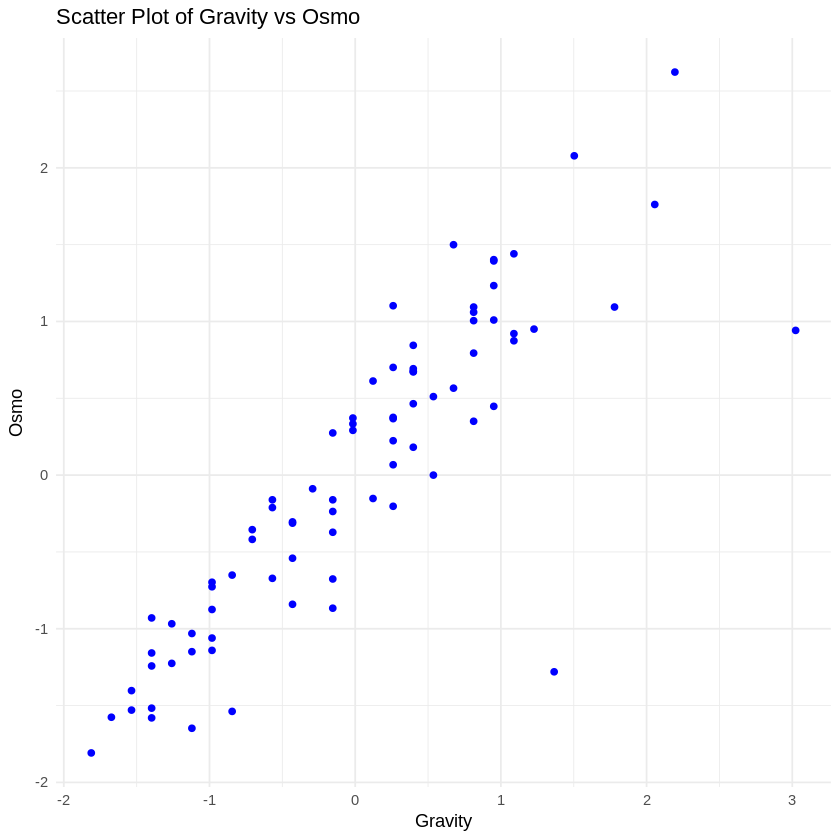

In [3]:
osmo_std <- (data$osmo - mean(data$osmo)) / sd(data$osmo)
gravity_std <- (data$gravity - mean(data$gravity)) / sd(data$gravity)

ggplot(data, aes(x = gravity_std, y = osmo_std)) +
  geom_point(color = "blue") +
  labs(x = "Gravity", y = "Osmo", title = "Scatter Plot of Gravity vs Osmo") +
  theme_minimal()

# Software

Bayesian inference utilizes a generative model to produce samples representative of the posterior distribution, before drawing inferences upon those samples. The popular C++ sampler Stan offers a way to do this, with APIs for many languages such as Python, R, Java, etc. Python also has a popular library named PyMC, and a library named bambi for linear modeling, which is built upon PyMC. We will use Stan, through the R library rstan.

# Implementation

The code we pass to Stan in text format is structured into blocks, including <code>data{}</code>, <code>parameters{}</code>, <code>model{}</code>, and <code>generated quantities{}</code>. These are the ones we’ll work with for now, though if you continue to work with Stan, you will come across others such as <code>functions{}</code> and <code>transformed data{}</code>.

The <code>data{}</code> block contains variables to be populated by passing in data from the R interface, with a list object provided to the <code>stan()</code> function. This will typically include at least an <code>N</code> variable for number of observations and a dependent variable of observed data.

In [ ]:
# data {
#   int<lower=0> N;
#   vector[N] x;
#   vector[N] y;
# }

<code>&lt;lower=0&gt;</code> constrains results to be greater or equal to zero, and any number can be specified in place of 0. Similarly, there is an upper keyword, and if we wanted to declare a binary variable, we could use <code>int<lower=0, upper=1></code>. For a non-integer number, we would replace <code>int</code> with <code>real</code>. A vector of elements of type <code>real</code> may be declared as <code>vector[N]</code>, where <code>N</code> represents the number of elements. For greater flexibility, i.e., when matrix-vector multiplication is not possible, one can create an array of elements of the desired data type by using syntax such as <code>int myarray[N]</code>.
    
The <code>parameters{}</code> block is for declaration of non-data variables (i.e., parameters) to be used in the modeling process. For the normal distribution we will use to model the data, we will declare the parameters <code>mu</code> and <code>sigma</code> as real-numbered variables, with <code>sigma</code> bounded at 0. Again, you could choose any other names, so long as they are fed into the normal distribution function in the appropriate positions when we get to the <code>model{}</code> block.

In [ ]:
# parameters {
#     real alpha;
#     real beta;
#     real<lower=0> sigma;
# }

In the <code>model{}</code> block, parameters are mapped to the data to be fit via modeling functions. We can declare a prior distribution on these parameters, or let <code>stan</code> assign a flat prior by default. The <code>~</code> operator is used (as 'drawn from'), rather than <code>=</code>. For the sake of simplicity in this first example, we will not yet set priors on the parameters.

In [ ]:
# model {
#     // Priors
#     alpha ~ normal(0, 0.1);
#     beta ~ normal(1, 0.1);
#     sigma ~ normal(0.5, 0.1);

#     // Likelihood
#     osmo ~ normal(alpha + beta * gravity, sigma);
# }

Finally, the <code>generated quantities{}</code> block is where we generate predictions from the fitted model. This is optional; if you are only interested in finding parameters, the <code>model{}</code> block is all you require, and I will show you how to extract them momentarily.

The variables used to store predictions must be declared at the top of this block. The differences between referring to a distribution in the <code>model{}</code> block and referring to a distribution in the <code>generated quantities{}</code> block are that:
1. In the <code>model{}</code> block we use the <code>~</code> operator whereas in the <code>generated quantities{}</code> block, we use <code>=</code>, and

2. When using the model to generate quantites, we append it with <code>_rng</code>.

In [ ]:
# generated quantities {
#   vector[N] osmo_pred;
#   for (n in 1:N)
#     osmo_pred[n] = normal_rng(alpha + beta * gravity[n], sigma);
# }

Putting it all together, we have compiled our C++ code for Stan.

In [4]:
stan_code <- "
data {
  int<lower=0> N;
  vector[N] gravity;
  vector[N] osmo;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    // Priors
    alpha ~ normal(0, 0.1);
    beta ~ normal(1, 0.1);
    sigma ~ normal(0.5, 0.1);

    // Likelihood
    osmo ~ normal(alpha + beta * gravity, sigma);
}

generated quantities {
  vector[N] osmo_pred;
  for (n in 1:N)
    osmo_pred[n] = normal_rng(alpha + beta * gravity[n], sigma);
}
"

The code is saved to the variable <code>stan_code</code>, which we will pass as the first argument to the <code>stan()</code> function in order to compile and fit the model. The list of data we're passing in consists of <code>N</code> and the standardized <code>gravity</code> and <code>osmo</code> data. <code>chains</code> refers to the number of sampling chains to run, and <code>iter</code> refers to the number of samples to draw per chain while fitting the model, which will correspond to the number of samples generated by the <code>generated quantities{}</code> block. It is a good idea to run multiple chains, in case one or more is divergent. <code>warmup</code> tells it to discard a certain amount of leading samples in each chain, as it can take a while for the sampler to focus in on the optimal space.
<code>refresh=0</code> suppresses the output while sampling, and <code>cores</code> tells it how many processors to use.

In [5]:
N <- nrow(data)
data_list <- list(N=N, gravity=gravity_std, osmo=osmo_std)
model_fit <- stan(model_code = stan_code, data = data_list, warmup = 1000,
                 iter = 3000, chains = 4, refresh = 0, cores = 4)

The returns of the function have been saved into the variable <code>model_fit</code>. Below, we run trace plots and density plots to validate the training process. We expect the time series' in the trace plots to be stationary but noisy, and the density plots to be approximately normal, with the various sampling chains behaving similarly (following the warm-up).

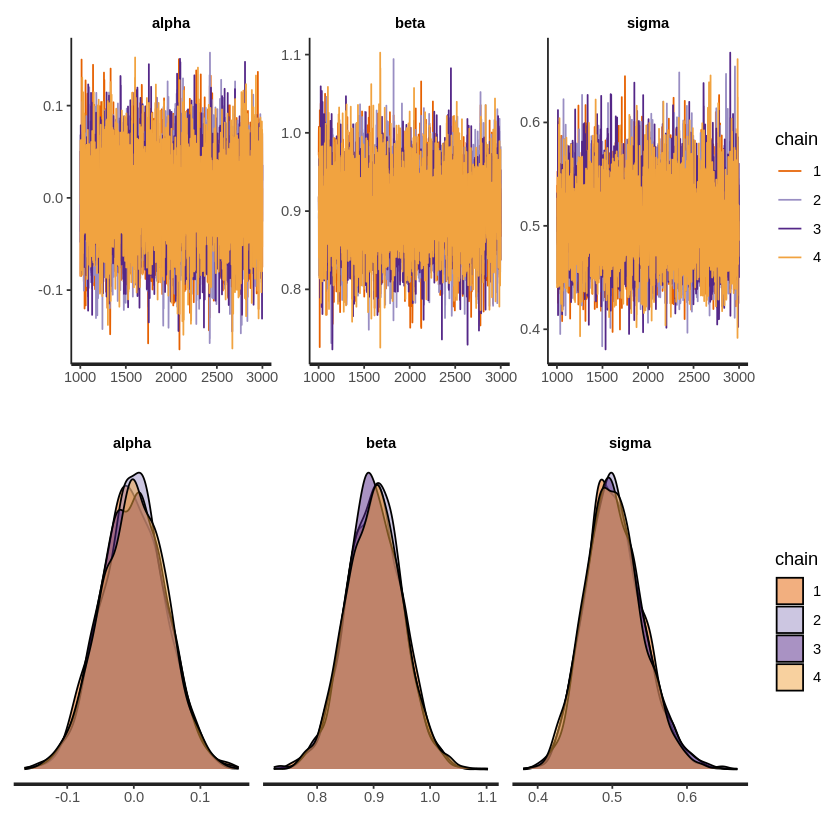

In [13]:
plot1 <- traceplot(model_fit, pars=c("alpha", "beta", "sigma"))
plot2 <- stan_dens(model_fit, separate_chains = TRUE, pars=c("alpha", "beta", "sigma"))
grid.arrange(plot1, plot2, ncol = 1)

We can summarize parameters found during sampling with something like the following:

In [6]:
print(model_fit, pars=c("alpha", "beta", "sigma"),
      probs=c(0.1, 0.5, 0.9), digits = 3)

Inference for Stan model: anon_model.
4 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean    sd    10%    50%   90% n_eff  Rhat
alpha -0.001   0.001 0.048 -0.064 -0.001 0.061  8675 1.001
beta   0.901   0.001 0.049  0.839  0.902 0.963  8171 1.000
sigma  0.503   0.000 0.038  0.455  0.501 0.554  8614 1.000

Samples were drawn using NUTS(diag_e) at Wed Jan  8 23:19:31 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Below, we plot the line of best fit found through Normal regression against the data in a scatter plot.

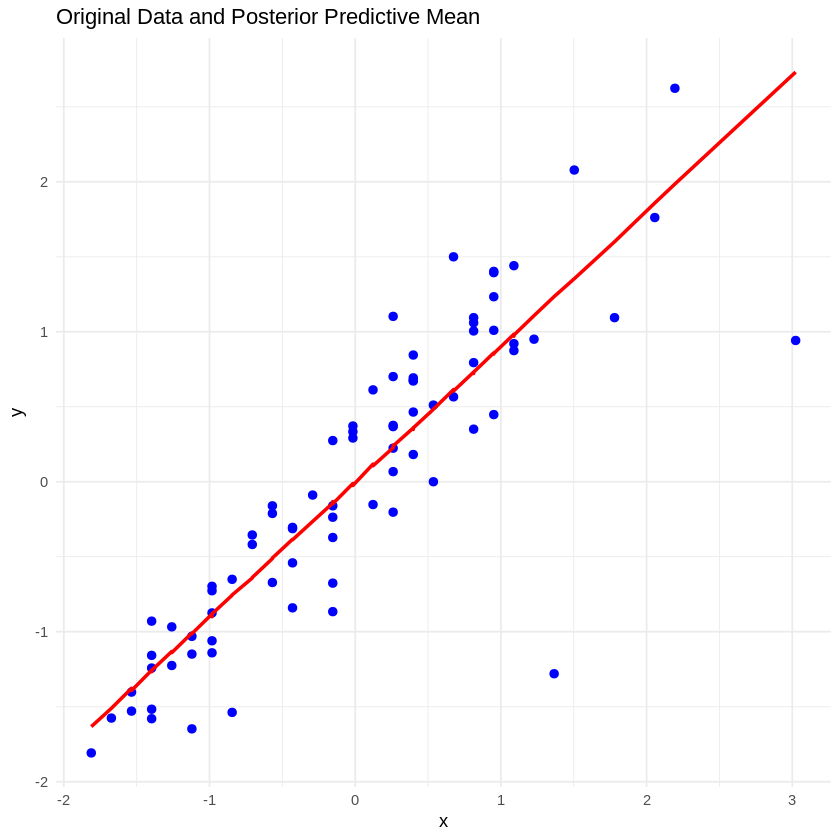

In [9]:
posterior_samples <- extract(model_fit)
y_pred_samples <- posterior_samples$osmo_pred
y_pred_mean <- apply(y_pred_samples, 2, mean)

ggplot(data.frame(x = gravity_std, y = osmo_std, y_pred = y_pred_mean), aes(x = x)) +
  geom_point(aes(y = y), color = "blue", size = 2) +
  geom_line(aes(y = y_pred), color = "red", linewidth = 1) +
  labs(title = "Original Data and Posterior Predictive Mean",
       x = "x", y = "y") +
  theme_minimal()

Notice how we have a couple of outliers. Neither are too extreme in the univariate sense, but given the linear trend which expresses the relationship of the two variables, they are significantly different from the crowd. Though only two points, the regression line tilts quite aggressively toward them, and this is not uncommon in linear regression. 

# Robust Linear Regression

Methods for robustness - i.e., avoiding a tilt toward outliers - can be achieved in various ways, such as quantile regression, or penalized regression. In the Bayesian context, we can make regression more robust by adjusting the distribution we use for the likelihood - i.e., using something like the t-distribution, which has heavier tails. The heavier tails allocate more probability to unlikely values, which has the effect of greater-centering the regression line upon the bulk of the data.

The below code is only adjusted slightly from the above. We replaced <code>normal</code> with <code>student_t</code> in the likelihood, <code>normal_rng</code> with <code>student_t_rng</code> in the generated quantities, and provided an additional argument preceding the mean and standard deviation, which is the degrees of freedom, set deterministically to 10. A word of caution is that the lower the degrees of freedom, the more correlated the simulated data will become.

Instead of the line:
- <code>osmo ~ normal(alpha + beta * gravity, sigma);</code>

we now have:
- <code>osmo ~ student_t(10, alpha + beta * gravity, sigma);</code>

and instead of the line:
- <code>osmo_pred[n] = normal_rng(alpha + beta * gravity[n], sigma);</code>

we now have:
- <code>osmo_pred[n] = student_t_rng(10, alpha + beta * gravity[n], sigma);</code>

In [14]:
stan_code <- "
data {
  int<lower=0> N;
  vector[N] gravity;
  vector[N] osmo;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    // Priors
    alpha ~ normal(0, 0.1);
    beta ~ normal(1, 0.1);
    sigma ~ normal(0.5, 0.1);

    // Likelihood
    osmo ~ student_t(10, alpha + beta * gravity, sigma);
}

generated quantities {
  vector[N] osmo_pred;
  for (n in 1:N)
    osmo_pred[n] = student_t_rng(10, alpha + beta * gravity[n], sigma);
}
"

We run the model,

In [15]:
N <- nrow(data)
data_list <- list(N=N, gravity=gravity_std, osmo=osmo_std)
model_fit <- stan(model_code = stan_code, data = data_list, warmup = 1000,
                 iter = 3000, chains = 4, refresh = 0, cores = 4)

Inspect the diagnostics,

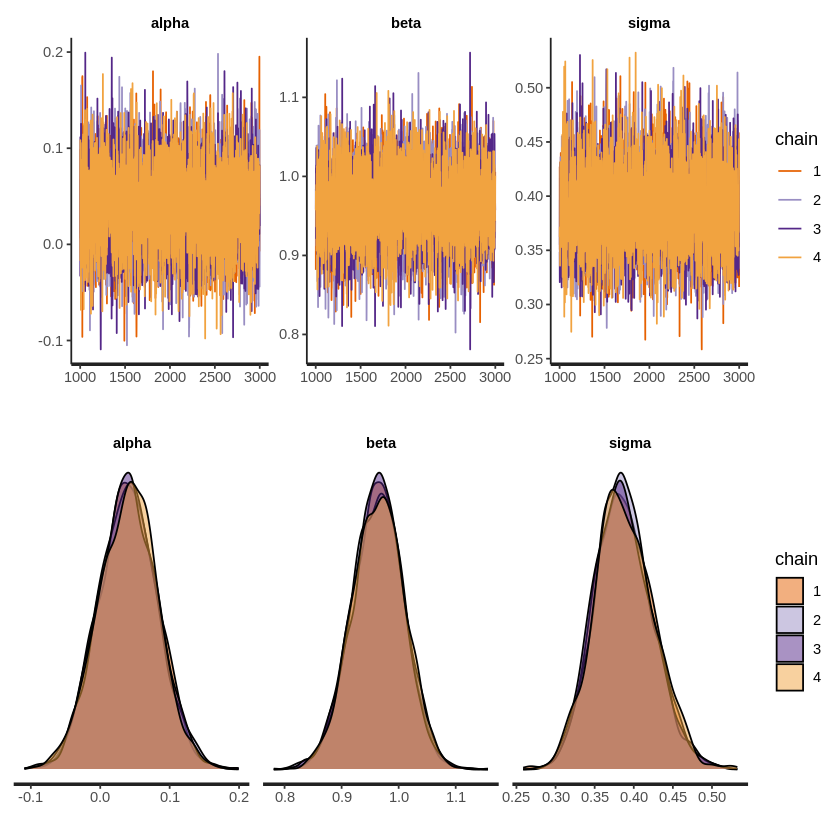

In [16]:
plot1 <- traceplot(model_fit, pars=c("alpha", "beta", "sigma"))
plot2 <- stan_dens(model_fit, separate_chains = TRUE, pars=c("alpha", "beta", "sigma"))
grid.arrange(plot1, plot2, ncol = 1)

and summarize the parameters found:

In [17]:
print(model_fit, pars=c("alpha", "beta", "sigma"),
      probs=c(0.1, 0.5, 0.9), digits = 3)

Inference for Stan model: anon_model.
4 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean    sd    10%   50%   90% n_eff Rhat
alpha 0.040   0.000 0.042 -0.015 0.040 0.093  7478    1
beta  0.964   0.001 0.045  0.905 0.965 1.021  7745    1
sigma 0.388   0.000 0.037  0.342 0.385 0.437  7047    1

Samples were drawn using NUTS(diag_e) at Wed Jan  8 23:28:02 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Then extract and plot the line of best fit from the posterior samples, and plot it against the data.

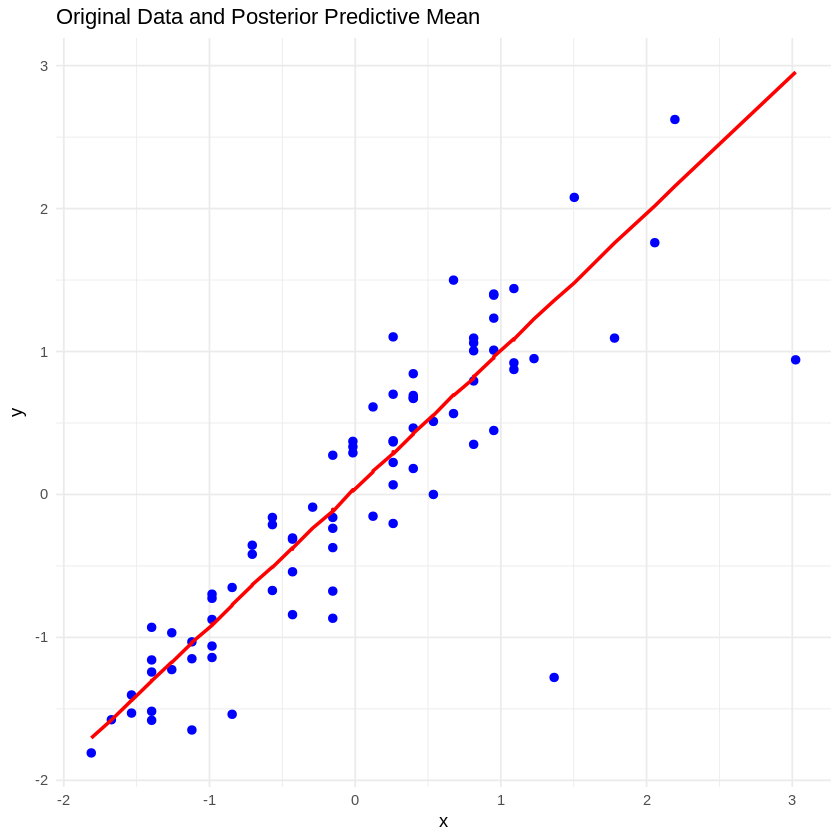

In [19]:
posterior_samples <- extract(model_fit)
y_pred_samples <- posterior_samples$osmo_pred
y_pred_mean <- apply(y_pred_samples, 2, mean)

ggplot(data.frame(x = gravity_std, y = osmo_std, y_pred = y_pred_mean), aes(x = x)) +
  geom_point(aes(y = y), color = "blue", size = 2) +
  geom_line(aes(y = y_pred), color = "red", linewidth = 1) +
  labs(title = "Original Data and Posterior Predictive Mean",
       x = "x", y = "y") +
  theme_minimal()

We see that it caters much less to the outliers (scroll up to take a look at the previous one if this is not obvious).

And just to provide the code that we would use if wanting to shade in a 95% highest density interval (HDI), based on the posterior samples:

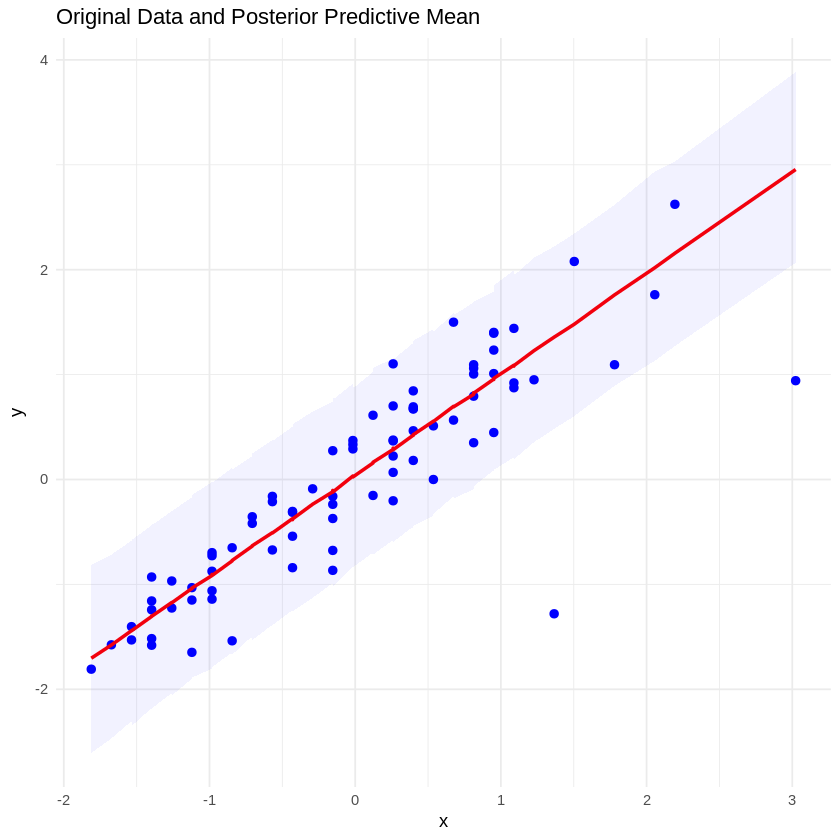

In [20]:
lower_bound <- apply(y_pred_samples, 2, function(x) quantile(x, 0.025))
upper_bound <- apply(y_pred_samples, 2, function(x) quantile(x, 0.975))

plot_data <- data.frame(
  x = gravity_std,
  y_fit = apply(y_pred_samples, 2, mean),  # Mean prediction
  y_lower = lower_bound,
  y_upper = upper_bound
)

ggplot(data.frame(x = gravity_std, y = osmo_std, y_pred = y_pred_mean), aes(x = x)) +
  geom_point(aes(y = y), color = "blue", size = 2) +
  geom_line(aes(y = y_pred), color = "red", linewidth = 1) +
  geom_ribbon(data = plot_data, aes(x = x, ymin = y_lower, ymax = y_upper), fill = "blue", alpha = 0.05) +  # HDI
  labs(title = "Original Data and Posterior Predictive Mean",
       x = "x", y = "y") +
  theme_minimal()

# What's Next?

We've explored Bayesian linear regression, and extended it from the Normal model to a Student-t model. Next, we'll discuss generalized linear models (GLMs), which can distribute the noise according to an arbitrary distribution, such as the Poisson, Negative Binomial, or Gamma, and constrain results to things like strictly positive numbers, or strictly positive integers.

# References

<u>Books:</u>

- Gelman, A., Carlin, J., Stern, H., Rubin, D., Dunson, D., & Vehtari, A. (1995). Bayesian Data Analysis (3rd ed.). https://www.researchgate.net/publication/46714374_Bayesian_data_analysis

- McElreath, R. (2017). Statistical Rethinking (2nd ed.). https://github.com/Booleans/statistical-rethinking/blob/master/Statistical%20Rethinking%202nd%20Edition.pdf

- Davidson-Pilon, C. Bayesian Methods for Hackers. https://dataorigami.net/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents


<u>Papers:</u>

- Gelman, A., & Hennig, C. (2017). Beyond subjective and objective in statistics. Columbia University. http://www.stat.columbia.edu/~gelman/research/published/objectivityr5.pdf

- Gelman, A., Simpson, D., & Betancourt, M. (2017). The Prior Can Often Only Be Understood in the Context of the Likelihood. Entropy. http://www.stat.columbia.edu/~gelman/research/unpublished/prior_context.pdf

- Kruschke, J. K., & Liddell, T. M. (2017). The Bayesian New Statistics. Psychonomic Society. https://doi.org/10.3758/s13423-016-1221-4


<u>Videos:</u>

- <a href="http://www.stat.columbia.edu/~gelman/videos/">Andrew Gelman Lectures</a>

- <a href="https://www.youtube.com/watch?v=FdnMWdICdRs&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus">Richard McElreath (Statistical Rethinking) Lectures</a>

<u>Other:</u>

- (2005, July 31). N is never large. Statistical Modeling, Causal Inference, and Social Science. https://statmodeling.stat.columbia.edu/2005/07/31/n_is_never_larg/

- <a href="https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations">stan-dev Prior Choice Recommendations</a>